In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "/content/spam.csv"
data = pd.read_csv(file_path, encoding='latin1')
num=100

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


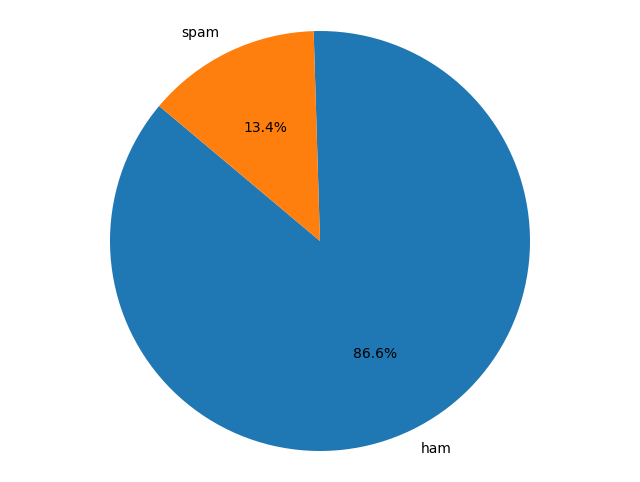

In [ ]:
data.shape
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)
data.head(5)
data['result'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(data['result'].value_counts(), labels=data['result'].value_counts().index, autopct='%1.1f%%', startangle=140)
#plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal')
plt.show()

In [ ]:
data.shape
#data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)
data
data.isnull().sum()
data.duplicated().sum()
data = data.drop_duplicates(keep='first')
data.shape
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


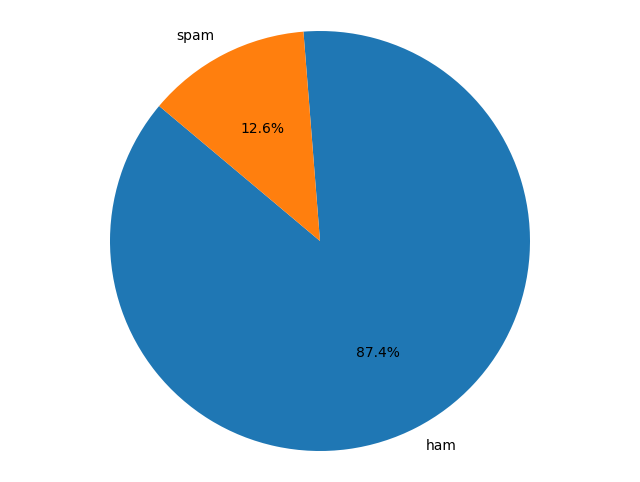

In [ ]:
data['result'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(data['result'].value_counts(), labels=data['result'].value_counts().index, autopct='%1.1f%%', startangle=140)
#plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- Class Balance ---
label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

Data is imbalanced.

--- Tabular Classification Report: Logistic Regression ---
              precision    recall  f1-score      support
0              0.957537  0.998893  0.977778   903.000000
1              0.989130  0.694656  0.816143   131.000000
accuracy       0.960348  0.960348  0.960348     0.960348
macro avg      0.973334  0.846775  0.896961  1034.000000
weighted avg   0.961540  0.960348  0.957300  1034.000000


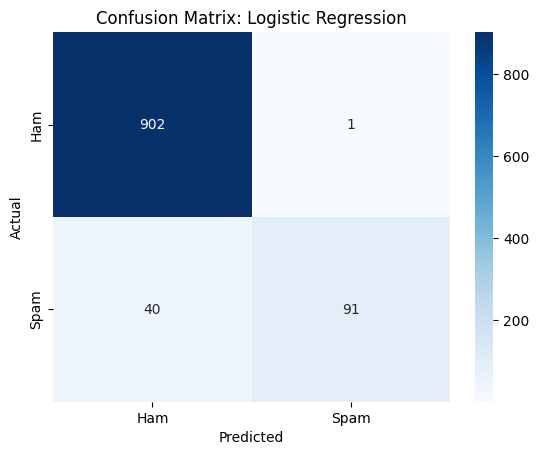


--- Tabular Classification Report: SVM ---
              precision    recall  f1-score      support
0              0.975162  1.000000  0.987425   903.000000
1              1.000000  0.824427  0.903766   131.000000
accuracy       0.977756  0.977756  0.977756     0.977756
macro avg      0.987581  0.912214  0.945595  1034.000000
weighted avg   0.978309  0.977756  0.976826  1034.000000


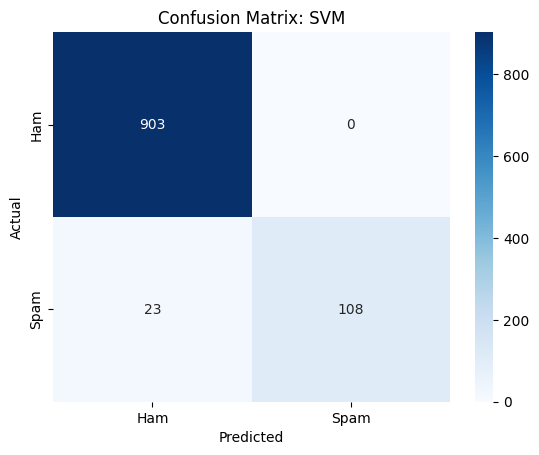


--- Tabular Classification Report: Naive Bayes ---
              precision    recall  f1-score      support
0              0.976216  1.000000  0.987965   903.000000
1              1.000000  0.832061  0.908333   131.000000
accuracy       0.978723  0.978723  0.978723     0.978723
macro avg      0.988108  0.916031  0.948149  1034.000000
weighted avg   0.979229  0.978723  0.977876  1034.000000


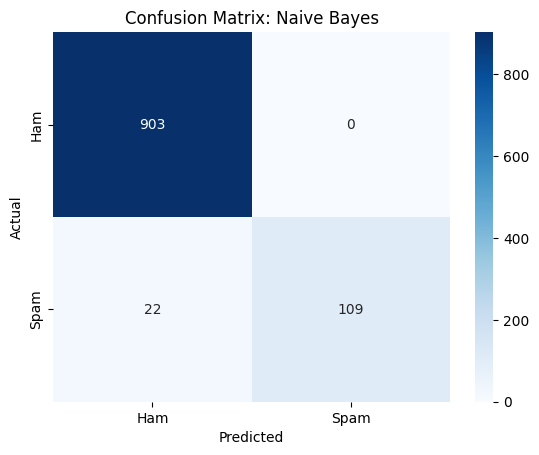


--- Tabular Classification Report: Random Forest ---
              precision    recall  f1-score      support
0              0.974110  1.000000  0.986885   903.000000
1              1.000000  0.816794  0.899160   131.000000
accuracy       0.976789  0.976789  0.976789     0.976789
macro avg      0.987055  0.908397  0.943022  1034.000000
weighted avg   0.977390  0.976789  0.975771  1034.000000


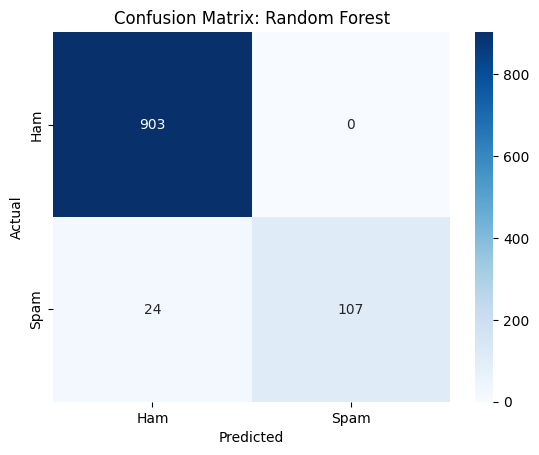

In [ ]:
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "/content/drive/MyDrive/spam.csv"
df = pd.read_csv(file_path, encoding='latin1')
num=100


# Rename the columns
df.columns = ['label', 'text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df = df[['label', 'text']]
df.isnull().sum()
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape
df.head(5)

# Encode the labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


# Check class balance
print("--- Class Balance ---")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts)
print(f"\nData is {'balanced' if all(class_counts > 0.4) else 'imbalanced'}.")


# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

# Labels
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=num)

# Initialize results list
model_results = []

def plot_heatmap(conf_matrix, model_name):
    """Plot confusion matrix heatmap."""
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Logistic Regression
logistic_model = LogisticRegression(random_state=num)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

logistic_report_df = pd.DataFrame(classification_report(y_test, y_pred_logistic, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Logistic Regression ---")
print(logistic_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_logistic)
plot_heatmap(conf_matrix, "Logistic Regression")

model_results.append(['Logistic Regression', accuracy_score(y_test, y_pred_logistic),
                      logistic_report_df.loc['0']['f1-score'], logistic_report_df.loc['1']['f1-score']])

# SVM
svm_model = SVC(random_state=num)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

svm_report_df = pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: SVM ---")
print(svm_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_svm)
plot_heatmap(conf_matrix, "SVM")

model_results.append(['SVM', accuracy_score(y_test, y_pred_svm),
                      svm_report_df.loc['0']['f1-score'], svm_report_df.loc['1']['f1-score']])

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

nb_report_df = pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Naive Bayes ---")
print(nb_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_nb)
plot_heatmap(conf_matrix, "Naive Bayes")

model_results.append(['Naive Bayes', accuracy_score(y_test, y_pred_nb),
                      nb_report_df.loc['0']['f1-score'], nb_report_df.loc['1']['f1-score']])

# Random Forest
rf_model = RandomForestClassifier(random_state=num)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_report_df = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Random Forest ---")
print(rf_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plot_heatmap(conf_matrix, "Random Forest")

model_results.append(['Random Forest', accuracy_score(y_test, y_pred_rf),
                      rf_report_df.loc['0']['f1-score'], rf_report_df.loc['1']['f1-score']])




--- Comparison of Models ---
                 Model  Accuracy  F1-Score (Class 0)  F1-Score (Class 1)
0  Logistic Regression  0.960348            0.977778            0.816143
1                  SVM  0.977756            0.987425            0.903766
2          Naive Bayes  0.978723            0.987965            0.908333
3        Random Forest  0.976789            0.986885            0.899160


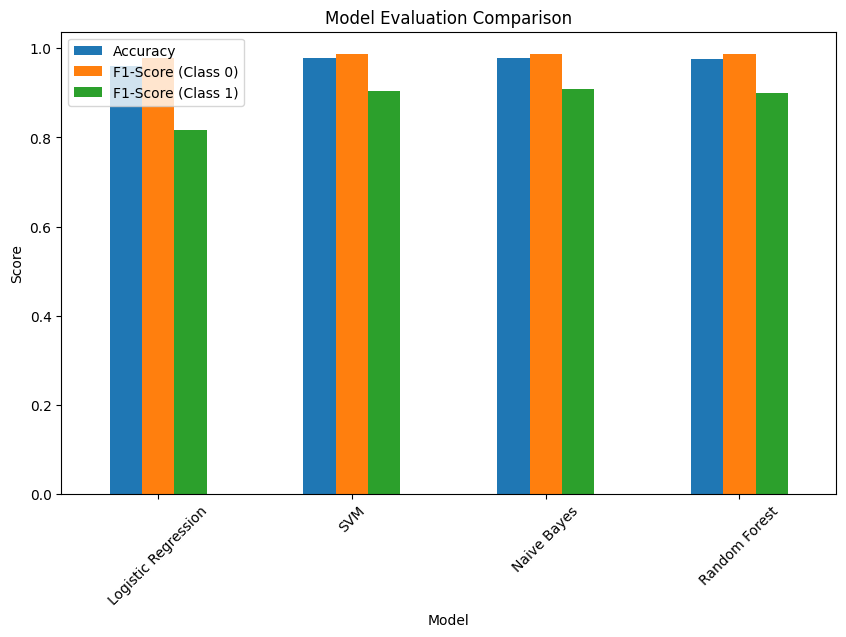

In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'F1-Score (Class 0)', 'F1-Score (Class 1)'])

print("\n--- Comparison of Models ---")
print(comparison_df)

# Plot comparison as a bar chart
comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Evaluation Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


# Class Weights Balance without Hyper Parameter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- Class Balance ---
label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

Data is imbalanced.

--- Tabular Classification Report: Logistic Regression ---
              precision    recall  f1-score      support
0              0.985604  0.985604  0.985604   903.000000
1              0.900763  0.900763  0.900763   131.000000
accuracy       0.974855  0.974855  0.974855     0.974855
macro avg      0.943183  0.943183  0.943183  1034.000000
weighted avg   0.974855  0.974855  0.974855  1034.000000


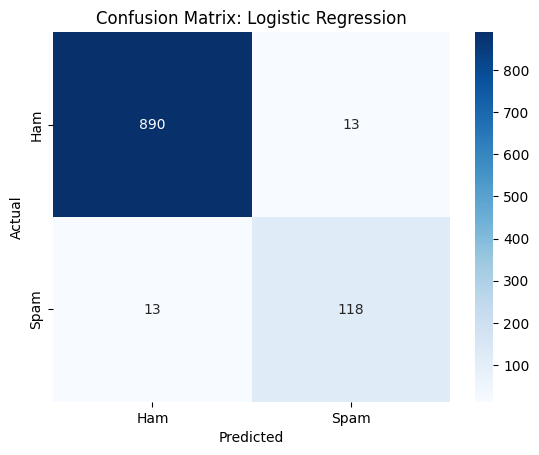


--- Tabular Classification Report: SVM ---
              precision    recall  f1-score      support
0              0.978308  0.998893  0.988493   903.000000
1              0.991071  0.847328  0.913580   131.000000
accuracy       0.979691  0.979691  0.979691     0.979691
macro avg      0.984690  0.923110  0.951037  1034.000000
weighted avg   0.979925  0.979691  0.979002  1034.000000


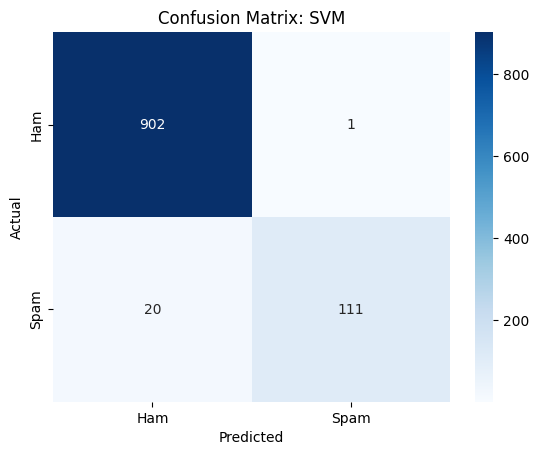


--- Tabular Classification Report: Naive Bayes ---
              precision    recall  f1-score      support
0              0.976216  1.000000  0.987965   903.000000
1              1.000000  0.832061  0.908333   131.000000
accuracy       0.978723  0.978723  0.978723     0.978723
macro avg      0.988108  0.916031  0.948149  1034.000000
weighted avg   0.979229  0.978723  0.977876  1034.000000


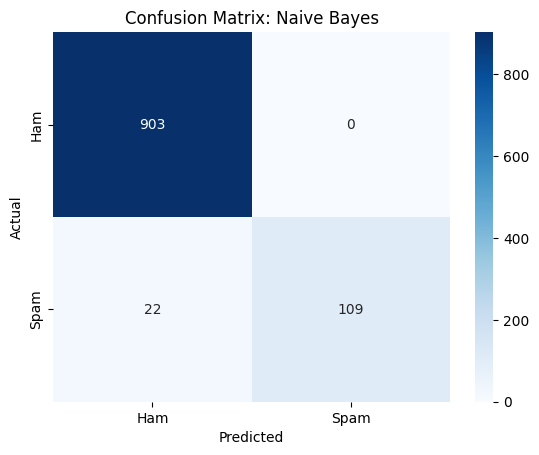


--- Tabular Classification Report: Random Forest ---
              precision    recall  f1-score      support
0              0.978308  0.998893  0.988493   903.000000
1              0.991071  0.847328  0.913580   131.000000
accuracy       0.979691  0.979691  0.979691     0.979691
macro avg      0.984690  0.923110  0.951037  1034.000000
weighted avg   0.979925  0.979691  0.979002  1034.000000


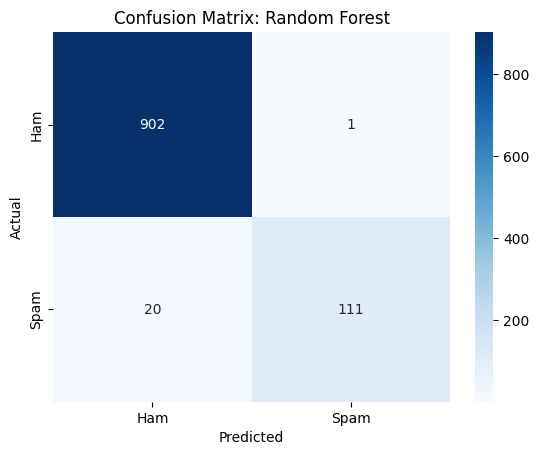


--- Comparison of Models --- Class Weights
                 Model  Accuracy  F1-Score (Class 0)  F1-Score (Class 1)
0  Logistic Regression  0.974855            0.985604            0.900763
1                  SVM  0.979691            0.988493            0.913580
2          Naive Bayes  0.978723            0.987965            0.908333
3        Random Forest  0.979691            0.988493            0.913580


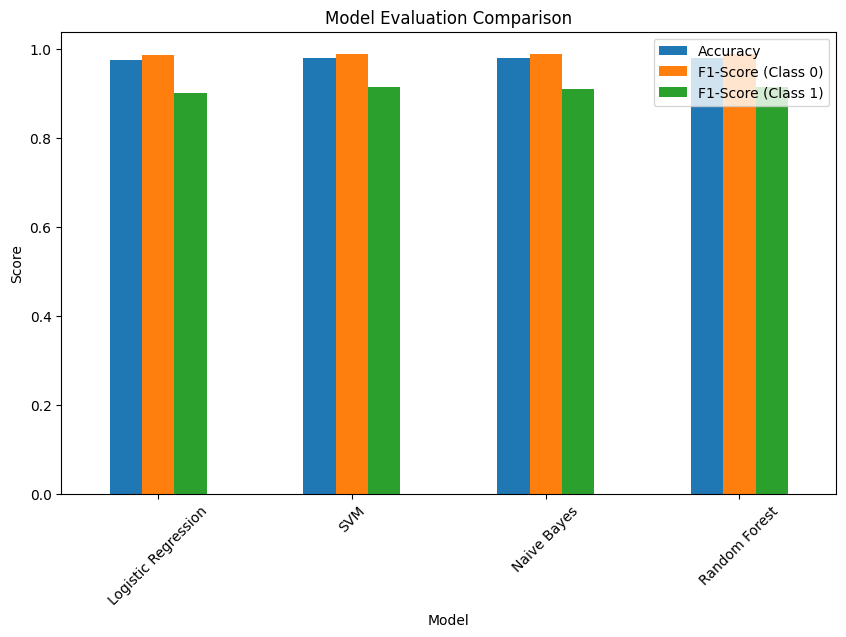

In [ ]:
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "/content/drive/MyDrive/spam.csv"
df = pd.read_csv(file_path, encoding='latin1')
num=100

# Rename the columns
df.columns = ['label', 'text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df = df[['label', 'text']]
df.isnull().sum()
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape
df.head(5)

# Encode the labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check class balance
print("--- Class Balance ---")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts)
print(f"\nData is {'balanced' if all(class_counts > 0.4) else 'imbalanced'}.")

# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

# Labels
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=num)

# Initialize results list
model_results = []

def plot_heatmap(conf_matrix, model_name):
    """Plot confusion matrix heatmap."""
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Logistic Regression
logistic_model = LogisticRegression(class_weight='balanced', random_state=num)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

logistic_report_df = pd.DataFrame(classification_report(y_test, y_pred_logistic, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Logistic Regression ---")
print(logistic_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_logistic)
plot_heatmap(conf_matrix, "Logistic Regression")

model_results.append(['Logistic Regression', accuracy_score(y_test, y_pred_logistic),
                      logistic_report_df.loc['0']['f1-score'], logistic_report_df.loc['1']['f1-score']])

# SVM
svm_model = SVC(class_weight='balanced', random_state=num)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

svm_report_df = pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: SVM ---")
print(svm_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_svm)
plot_heatmap(conf_matrix, "SVM")

model_results.append(['SVM', accuracy_score(y_test, y_pred_svm),
                      svm_report_df.loc['0']['f1-score'], svm_report_df.loc['1']['f1-score']])

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

nb_report_df = pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Naive Bayes ---")
print(nb_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_nb)
plot_heatmap(conf_matrix, "Naive Bayes")

model_results.append(['Naive Bayes', accuracy_score(y_test, y_pred_nb),
                      nb_report_df.loc['0']['f1-score'], nb_report_df.loc['1']['f1-score']])

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=num)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_report_df = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Random Forest ---")
print(rf_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plot_heatmap(conf_matrix, "Random Forest")

model_results.append(['Random Forest', accuracy_score(y_test, y_pred_rf),
                      rf_report_df.loc['0']['f1-score'], rf_report_df.loc['1']['f1-score']])


# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'F1-Score (Class 0)', 'F1-Score (Class 1)'])

print("\n--- Comparison of Models --- Class Weights")
print(comparison_df)

# Plot comparison as a bar chart
comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Evaluation Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


# SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- Class Balance ---
label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

Data is imbalanced.

--- Tabular Classification Report: Logistic Regression ---
              precision    recall  f1-score      support
0              0.986696  0.985604  0.986150   903.000000
1              0.901515  0.908397  0.904943   131.000000
accuracy       0.975822  0.975822  0.975822     0.975822
macro avg      0.944106  0.947000  0.945546  1034.000000
weighted avg   0.975904  0.975822  0.975861  1034.000000


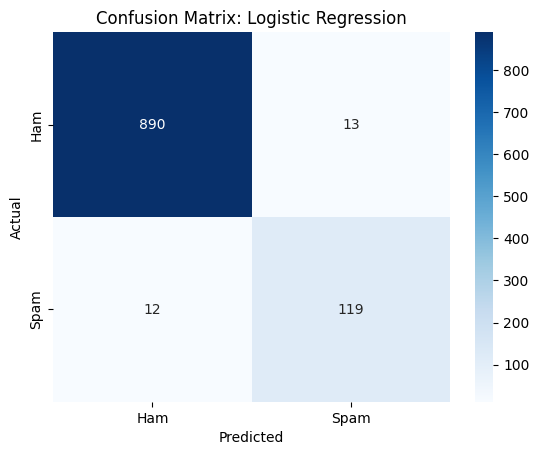


--- Tabular Classification Report: SVM ---
              precision    recall  f1-score      support
0              0.973970  0.994463  0.984110   903.000000
1              0.955357  0.816794  0.880658   131.000000
accuracy       0.971954  0.971954  0.971954     0.971954
macro avg      0.964663  0.905628  0.932384  1034.000000
weighted avg   0.971612  0.971954  0.971003  1034.000000


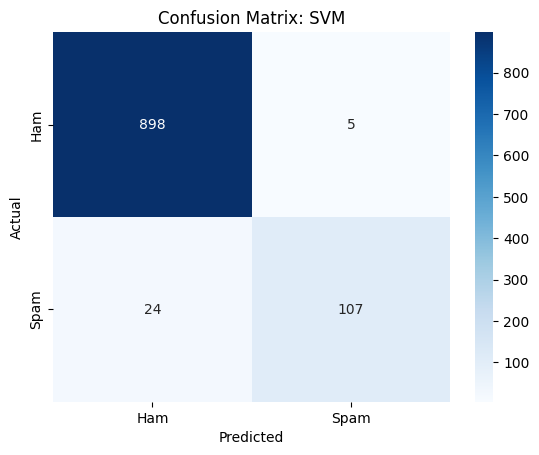


--- Tabular Classification Report: Naive Bayes ---
              precision    recall  f1-score      support
0              0.989796  0.966777  0.978151   903.000000
1              0.802632  0.931298  0.862191   131.000000
accuracy       0.962282  0.962282  0.962282     0.962282
macro avg      0.896214  0.949038  0.920171  1034.000000
weighted avg   0.966084  0.962282  0.963460  1034.000000


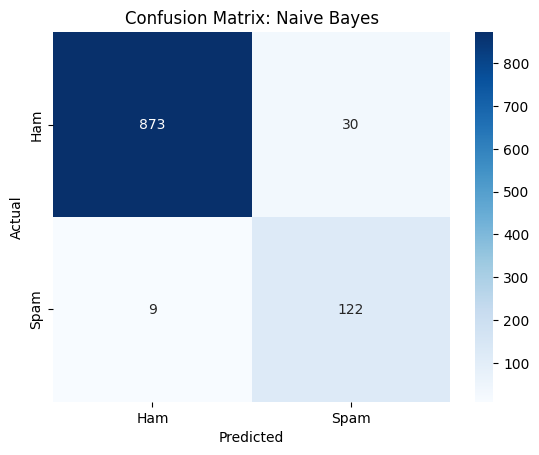


--- Tabular Classification Report: Random Forest ---
              precision    recall  f1-score      support
0              0.983589  0.995570  0.989543   903.000000
1              0.966667  0.885496  0.924303   131.000000
accuracy       0.981625  0.981625  0.981625     0.981625
macro avg      0.975128  0.940533  0.956923  1034.000000
weighted avg   0.981445  0.981625  0.981278  1034.000000


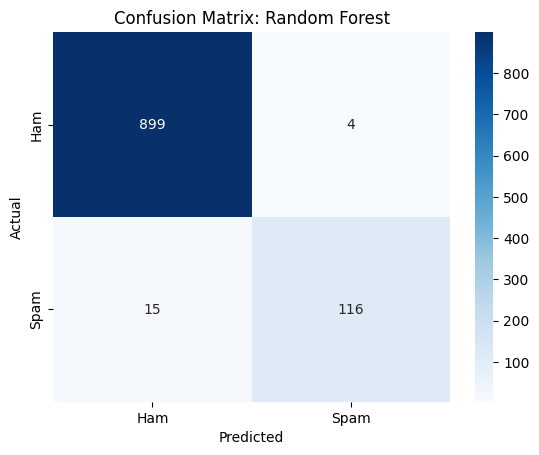


--- Comparison of Models - SMOTE ---
                 Model  Accuracy  F1-Score (Class 0)  F1-Score (Class 1)
0  Logistic Regression  0.975822            0.986150            0.904943
1                  SVM  0.971954            0.984110            0.880658
2          Naive Bayes  0.962282            0.978151            0.862191
3        Random Forest  0.981625            0.989543            0.924303


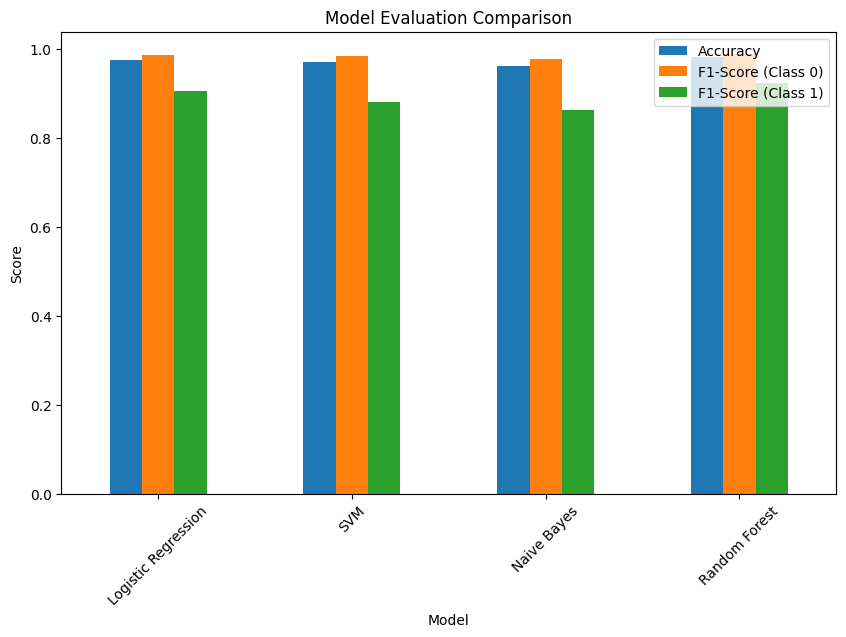

In [ ]:
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os
from imblearn.over_sampling import SMOTE

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "/content/drive/MyDrive/spam.csv"
df = pd.read_csv(file_path, encoding='latin1')
num=100

# Rename the columns
df.columns = ['label', 'text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df = df[['label', 'text']]
df.isnull().sum()
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape
df.head(5)

# Encode the labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check class balance
print("--- Class Balance ---")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts)
print(f"\nData is {'balanced' if all(class_counts > 0.4) else 'imbalanced'}.")

# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

# Labels
y = df['label']

# Split the data
x_old_train, X_test, y_old_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=num)

# Apply SMOTE to balance the training data (NOT TEST DATA!)
smote = SMOTE(random_state=num)
X_train, y_train = smote.fit_resample(x_old_train, y_old_train)

# Initialize results list
model_results = []

def plot_heatmap(conf_matrix, model_name):
    """Plot confusion matrix heatmap."""
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Logistic Regression
logistic_model = LogisticRegression(random_state=num)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

logistic_report_df = pd.DataFrame(classification_report(y_test, y_pred_logistic, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Logistic Regression ---")
print(logistic_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_logistic)
plot_heatmap(conf_matrix, "Logistic Regression")

model_results.append(['Logistic Regression', accuracy_score(y_test, y_pred_logistic),
                      logistic_report_df.loc['0']['f1-score'], logistic_report_df.loc['1']['f1-score']])

# SVM
svm_model = SVC(random_state=num)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

svm_report_df = pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: SVM ---")
print(svm_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_svm)
plot_heatmap(conf_matrix, "SVM")

model_results.append(['SVM', accuracy_score(y_test, y_pred_svm),
                      svm_report_df.loc['0']['f1-score'], svm_report_df.loc['1']['f1-score']])

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

nb_report_df = pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Naive Bayes ---")
print(nb_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_nb)
plot_heatmap(conf_matrix, "Naive Bayes")

model_results.append(['Naive Bayes', accuracy_score(y_test, y_pred_nb),
                      nb_report_df.loc['0']['f1-score'], nb_report_df.loc['1']['f1-score']])

# Random Forest
rf_model = RandomForestClassifier(random_state=num)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_report_df = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Random Forest ---")
print(rf_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plot_heatmap(conf_matrix, "Random Forest")

model_results.append(['Random Forest', accuracy_score(y_test, y_pred_rf),
                      rf_report_df.loc['0']['f1-score'], rf_report_df.loc['1']['f1-score']])

# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'F1-Score (Class 0)', 'F1-Score (Class 1)'])

print("\n--- Comparison of Models - SMOTE ---")
print(comparison_df)

# Plot comparison as a bar chart
comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Evaluation Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


# Hyper Parameter Tuning

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- Class Balance ---
label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

Data is imbalanced.

--- Tabular Classification Report: Logistic Regression ---
              precision    recall  f1-score      support
0              0.979370  0.998893  0.989035   903.000000
1              0.991150  0.854962  0.918033   131.000000
accuracy       0.980658  0.980658  0.980658     0.980658
macro avg      0.985260  0.926927  0.953534  1034.000000
weighted avg   0.980863  0.980658  0.980040  1034.000000


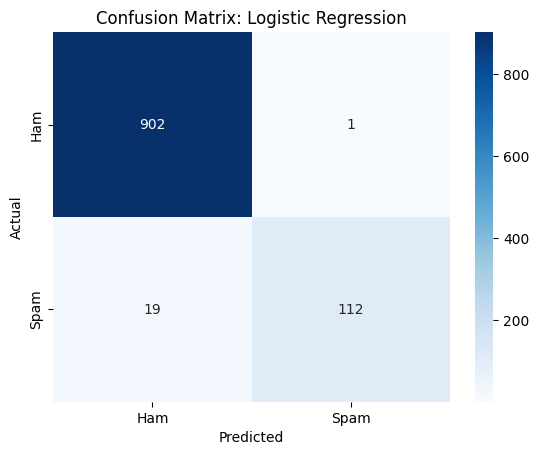


--- Tabular Classification Report: SVM ---
              precision    recall  f1-score      support
0              0.986799  0.993355  0.990066   903.000000
1              0.952000  0.908397  0.929688   131.000000
accuracy       0.982592  0.982592  0.982592     0.982592
macro avg      0.969399  0.950876  0.959877  1034.000000
weighted avg   0.982390  0.982592  0.982417  1034.000000


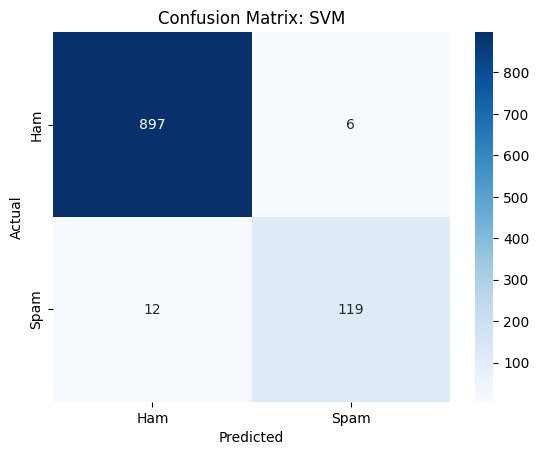


--- Tabular Classification Report: Naive Bayes ---
              precision    recall  f1-score      support
0              0.988975  0.993355  0.991160   903.000000
1              0.952756  0.923664  0.937984   131.000000
accuracy       0.984526  0.984526  0.984526     0.984526
macro avg      0.970865  0.958510  0.964572  1034.000000
weighted avg   0.984386  0.984526  0.984423  1034.000000


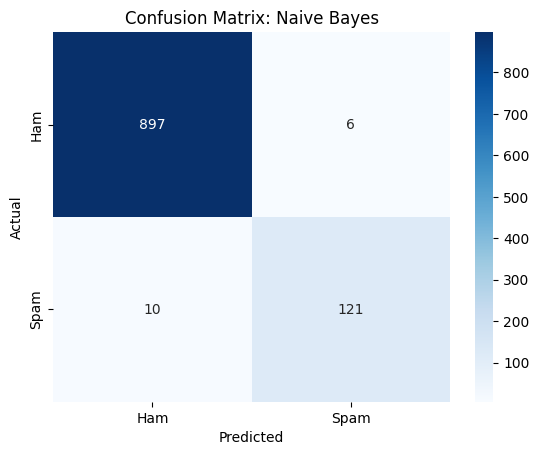


--- Tabular Classification Report: Random Forest ---
              precision    recall  f1-score      support
0              0.978284  0.997785  0.987939   903.000000
1              0.982301  0.847328  0.909836   131.000000
accuracy       0.978723  0.978723  0.978723     0.978723
macro avg      0.980293  0.922557  0.948887  1034.000000
weighted avg   0.978793  0.978723  0.978044  1034.000000


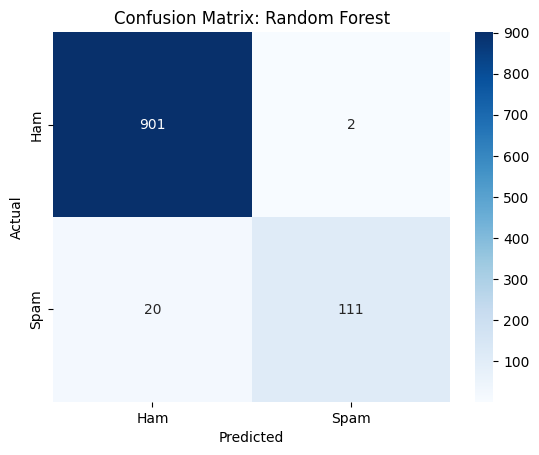


--- Comparison of Models HyperParameter Tuning---
                 Model  Accuracy  F1-Score (Class 0)  F1-Score (Class 1)
0  Logistic Regression  0.980658            0.989035            0.918033
1                  SVM  0.982592            0.990066            0.929688
2          Naive Bayes  0.984526            0.991160            0.937984
3        Random Forest  0.978723            0.987939            0.909836


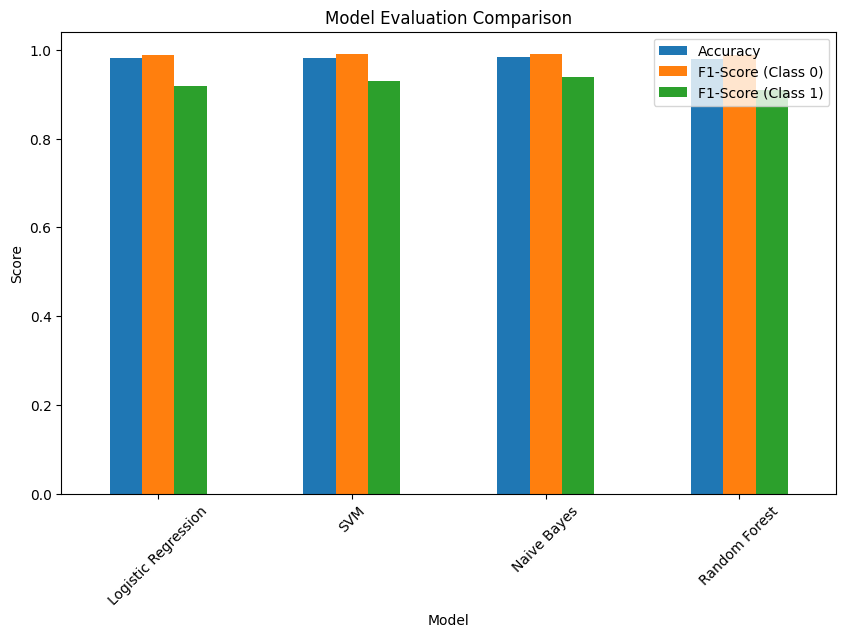

In [ ]:
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "/content/drive/MyDrive/spam.csv"
df = pd.read_csv(file_path, encoding='latin1')
num=100

# Rename the columns
df.columns = ['label', 'text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df = df[['label', 'text']]
df.isnull().sum()
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape
df.head(5)

# Encode the labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check class balance
print("--- Class Balance ---")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts)
print(f"\nData is {'balanced' if all(class_counts > 0.4) else 'imbalanced'}.")

# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

# Labels
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=num)

# Initialize results list
model_results = []

def plot_heatmap(conf_matrix, model_name):
    """Plot confusion matrix heatmap."""
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Logistic Regression
logistic_params = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
logistic_model = GridSearchCV(LogisticRegression(random_state=num), logistic_params, cv=5, n_jobs=-1)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

logistic_report_df = pd.DataFrame(classification_report(y_test, y_pred_logistic, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Logistic Regression ---")
print(logistic_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_logistic)
plot_heatmap(conf_matrix, "Logistic Regression")

model_results.append(['Logistic Regression', accuracy_score(y_test, y_pred_logistic),
                      logistic_report_df.loc['0']['f1-score'], logistic_report_df.loc['1']['f1-score']])

# SVM
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(random_state=num), svm_params, cv=5, n_jobs=-1)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

svm_report_df = pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: SVM ---")
print(svm_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_svm)
plot_heatmap(conf_matrix, "SVM")

model_results.append(['SVM', accuracy_score(y_test, y_pred_svm),
                      svm_report_df.loc['0']['f1-score'], svm_report_df.loc['1']['f1-score']])

# Naive Bayes
nb_params = {'alpha': [0.1, 0.5, 1.0]}
nb_model = GridSearchCV(MultinomialNB(), nb_params, cv=5, n_jobs=-1)
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

nb_report_df = pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Naive Bayes ---")
print(nb_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_nb)
plot_heatmap(conf_matrix, "Naive Bayes")

model_results.append(['Naive Bayes', accuracy_score(y_test, y_pred_nb),
                      nb_report_df.loc['0']['f1-score'], nb_report_df.loc['1']['f1-score']])

# Random Forest
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=num), rf_params, cv=5, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_report_df = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Random Forest ---")
print(rf_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plot_heatmap(conf_matrix, "Random Forest")

model_results.append(['Random Forest', accuracy_score(y_test, y_pred_rf),
                      rf_report_df.loc['0']['f1-score'], rf_report_df.loc['1']['f1-score']])


# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'F1-Score (Class 0)', 'F1-Score (Class 1)'])

print("\n--- Comparison of Models HyperParameter Tuning---")
print(comparison_df)

# Plot comparison as a bar chart
comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Evaluation Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


# Class Weights Balance

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- Class Balance ---
label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

Data is imbalanced.

--- Tabular Classification Report: Logistic Regression ---
              precision    recall  f1-score      support
0              0.986755  0.990033  0.988391   903.000000
1              0.929688  0.908397  0.918919   131.000000
accuracy       0.979691  0.979691  0.979691     0.979691
macro avg      0.958221  0.949215  0.953655  1034.000000
weighted avg   0.979525  0.979691  0.979590  1034.000000


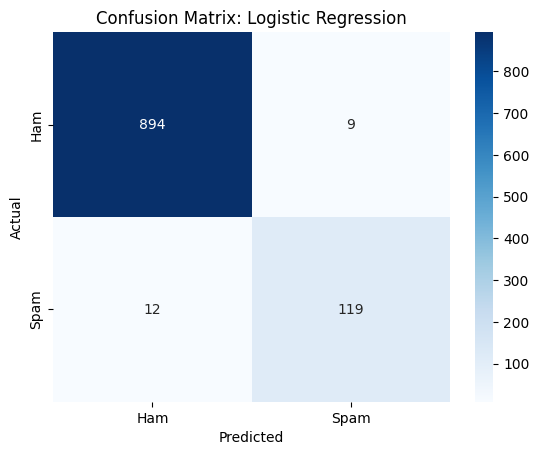


--- Tabular Classification Report: SVM ---
              precision    recall  f1-score      support
0              0.985746  0.995570  0.990634   903.000000
1              0.967213  0.900763  0.932806   131.000000
accuracy       0.983559  0.983559  0.983559     0.983559
macro avg      0.976479  0.948167  0.961720  1034.000000
weighted avg   0.983398  0.983559  0.983307  1034.000000


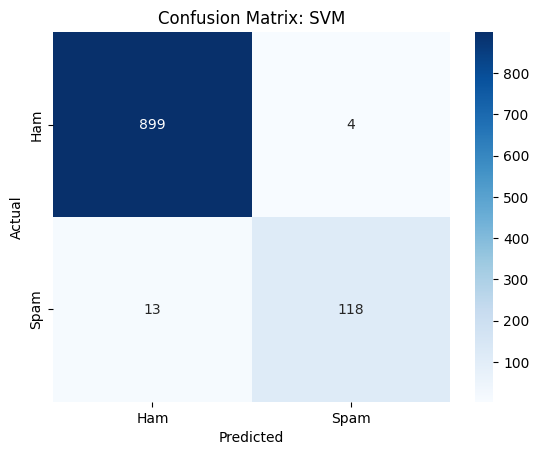


--- Tabular Classification Report: Naive Bayes ---
              precision    recall  f1-score      support
0              0.988975  0.993355  0.991160   903.000000
1              0.952756  0.923664  0.937984   131.000000
accuracy       0.984526  0.984526  0.984526     0.984526
macro avg      0.970865  0.958510  0.964572  1034.000000
weighted avg   0.984386  0.984526  0.984423  1034.000000


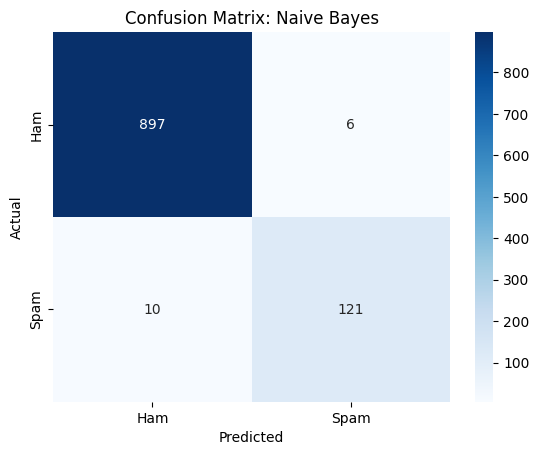


--- Tabular Classification Report: Random Forest ---
              precision    recall  f1-score      support
0              0.983571  0.994463  0.988987   903.000000
1              0.958678  0.885496  0.920635   131.000000
accuracy       0.980658  0.980658  0.980658     0.980658
macro avg      0.971124  0.939980  0.954811  1034.000000
weighted avg   0.980417  0.980658  0.980327  1034.000000


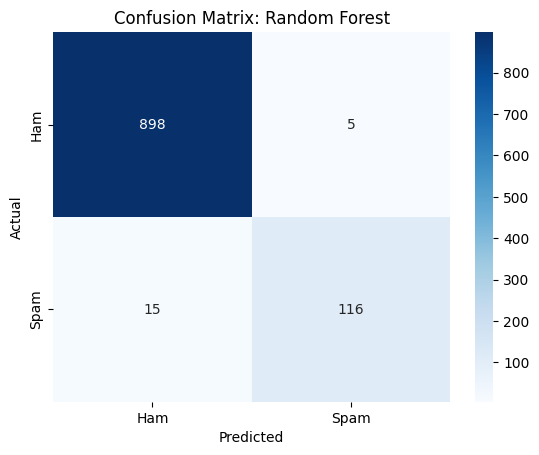

In [ ]:

import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "/content/drive/MyDrive/spam.csv"
df = pd.read_csv(file_path, encoding='latin1')
num=100

# Rename the columns
df.columns = ['label', 'text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df = df[['label', 'text']]
df.isnull().sum()
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape
df.head(5)
# Encode the labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check class balance
print("--- Class Balance ---")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts)
print(f"\nData is {'balanced' if all(class_counts > 0.4) else 'imbalanced'}.")

# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

# Labels
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=num)

# Initialize results list
model_results = []

def plot_heatmap(conf_matrix, model_name):
    """Plot confusion matrix heatmap."""
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Logistic Regression
logistic_params = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
logistic_model = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=num), logistic_params, cv=5, n_jobs=-1)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

logistic_report_df = pd.DataFrame(classification_report(y_test, y_pred_logistic, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Logistic Regression ---")
print(logistic_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_logistic)
plot_heatmap(conf_matrix, "Logistic Regression")

model_results.append(['Logistic Regression', accuracy_score(y_test, y_pred_logistic),
                      logistic_report_df.loc['0']['f1-score'], logistic_report_df.loc['1']['f1-score']])

# SVM
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(class_weight='balanced', random_state=num), svm_params, cv=5, n_jobs=-1)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

svm_report_df = pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: SVM ---")
print(svm_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_svm)
plot_heatmap(conf_matrix, "SVM")

model_results.append(['SVM', accuracy_score(y_test, y_pred_svm),
                      svm_report_df.loc['0']['f1-score'], svm_report_df.loc['1']['f1-score']])

# Naive Bayes
nb_params = {'alpha': [0.1, 0.5, 1.0]}
nb_model = GridSearchCV(MultinomialNB(), nb_params, cv=5, n_jobs=-1)
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

nb_report_df = pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Naive Bayes ---")
print(nb_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_nb)
plot_heatmap(conf_matrix, "Naive Bayes")

model_results.append(['Naive Bayes', accuracy_score(y_test, y_pred_nb),
                      nb_report_df.loc['0']['f1-score'], nb_report_df.loc['1']['f1-score']])

# Random Forest
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf_model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=num), rf_params, cv=5, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_report_df = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Random Forest ---")
print(rf_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plot_heatmap(conf_matrix, "Random Forest")

model_results.append(['Random Forest', accuracy_score(y_test, y_pred_rf),
                      rf_report_df.loc['0']['f1-score'], rf_report_df.loc['1']['f1-score']])



--- Comparison of Models Balanced Class Weights-Hyper ---
                 Model  Accuracy  F1-Score (Class 0)  F1-Score (Class 1)
0  Logistic Regression  0.979691            0.988391            0.918919
1                  SVM  0.983559            0.990634            0.932806
2          Naive Bayes  0.984526            0.991160            0.937984
3        Random Forest  0.980658            0.988987            0.920635


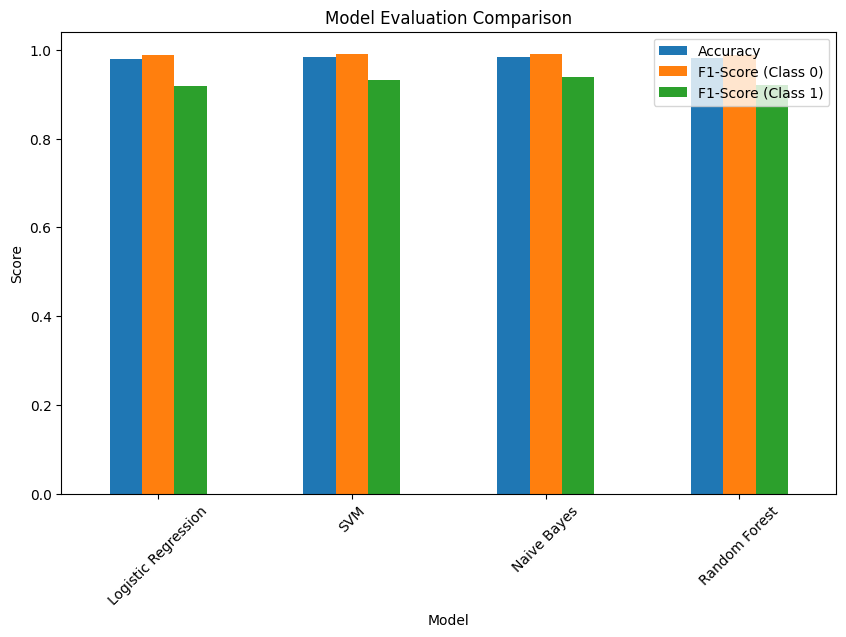

In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'F1-Score (Class 0)', 'F1-Score (Class 1)'])

print("\n--- Comparison of Models Balanced Class Weights-Hyper ---")
print(comparison_df)

# Plot comparison as a bar chart
comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Evaluation Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


# SMOTE

# SMOTE without Class Weights HyperParam

--- Class Balance Before SMOTE ---
label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

Data is imbalanced.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- Class Balance After Preprocessing ---
label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

Data is imbalanced.
--- Class Balance After SMOTE ---
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Data is balanced.

--- Tabular Classification Report: Logistic Regression ---
              precision    recall  f1-score      support
0              0.988864  0.983389  0.986119   903.000000
1              0.889706  0.923664  0.906367   131.000000
accuracy       0.975822  0.975822  0.975822     0.975822
macro avg      0.939285  0.953526  0.946243  1034.000000
weighted avg   0.976302  0.975822  0.976015  1034.000000


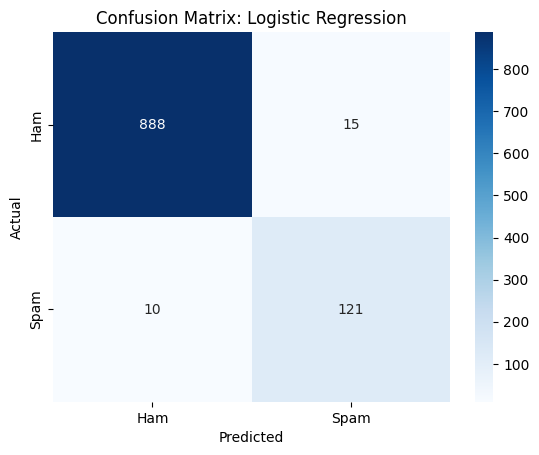


--- Tabular Classification Report: SVM ---
              precision    recall  f1-score      support
0              0.977149  0.994463  0.985730   903.000000
1              0.956522  0.839695  0.894309   131.000000
accuracy       0.974855  0.974855  0.974855     0.974855
macro avg      0.966835  0.917079  0.940019  1034.000000
weighted avg   0.974536  0.974855  0.974148  1034.000000


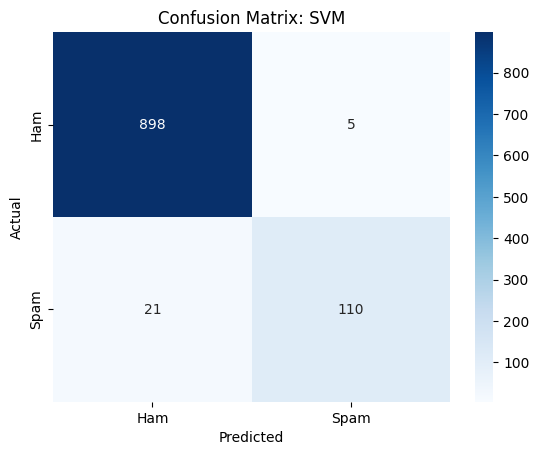


--- Tabular Classification Report: Naive Bayes ---
              precision    recall  f1-score      support
0              0.988751  0.973422  0.981027   903.000000
1              0.834483  0.923664  0.876812   131.000000
accuracy       0.967118  0.967118  0.967118     0.967118
macro avg      0.911617  0.948543  0.928919  1034.000000
weighted avg   0.969207  0.967118  0.967824  1034.000000


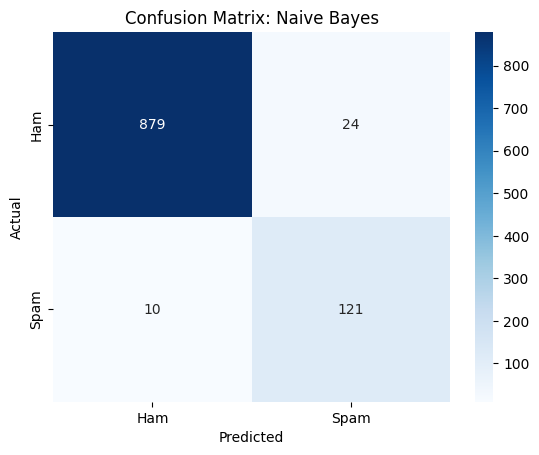


--- Tabular Classification Report: Random Forest ---
              precision    recall  f1-score      support
0              0.983589  0.995570  0.989543   903.000000
1              0.966667  0.885496  0.924303   131.000000
accuracy       0.981625  0.981625  0.981625     0.981625
macro avg      0.975128  0.940533  0.956923  1034.000000
weighted avg   0.981445  0.981625  0.981278  1034.000000


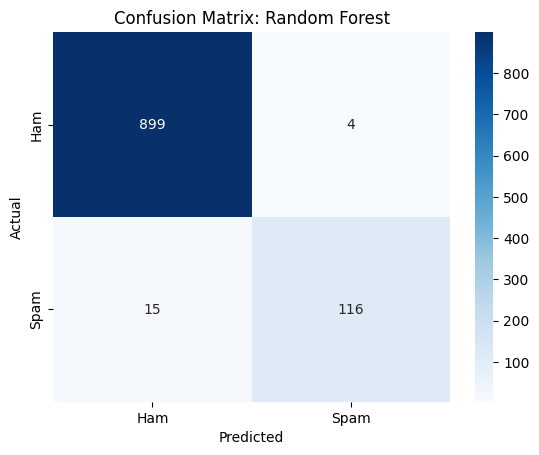


--- Model Comparison -Hyper SMOTE---
                 Model  Accuracy  F1-score (Ham)  F1-score (Spam)
0  Logistic Regression  0.975822        0.986119         0.906367
1                  SVM  0.974855        0.985730         0.894309
2          Naive Bayes  0.967118        0.981027         0.876812
3        Random Forest  0.981625        0.989543         0.924303


In [ ]:

import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os
from imblearn.over_sampling import SMOTE

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "/content/drive/MyDrive/spam.csv"
df = pd.read_csv(file_path, encoding='latin1')
num=100

# Rename the columns
df.columns = ['label', 'text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df = df[['label', 'text']]
df.isnull().sum()
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape
df.head(5)

# Encode the labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check class balance before SMOTE
print("--- Class Balance Before SMOTE ---")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts)
print(f"\nData is {'balanced' if all(class_counts > 0.4) else 'imbalanced'}.")

# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

# Check class balance after text preprocessing
print("--- Class Balance After Preprocessing ---")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts)

# Determine if data is balanced after preprocessing
if all(class_counts > 0.4):
    print(f"\nData is balanced.")
else:
    print(f"\nData is imbalanced.")

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

# Labels
y = df['label']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=num)

# Apply SMOTE to balance the training data (NOT TEST DATA!)
smote = SMOTE(random_state=num)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class balance after SMOTE
print("--- Class Balance After SMOTE ---")
class_counts_balanced = pd.Series(y_train_balanced).value_counts(normalize=True)
print(class_counts_balanced)
print(f"\nData is {'balanced' if all(class_counts_balanced > 0.4) else 'imbalanced'}.")

# Initialize results list to store model evaluation results
model_results = []

def plot_heatmap(conf_matrix, model_name):
    """Plot confusion matrix heatmap."""
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Logistic Regression
logistic_params = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
logistic_model = GridSearchCV(LogisticRegression(random_state=num), logistic_params, cv=5, n_jobs=-1)
logistic_model.fit(X_train_balanced, y_train_balanced)
y_pred_logistic = logistic_model.predict(X_test)

logistic_report_df = pd.DataFrame(classification_report(y_test, y_pred_logistic, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Logistic Regression ---")
print(logistic_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_logistic)
plot_heatmap(conf_matrix, "Logistic Regression")

model_results.append(['Logistic Regression', accuracy_score(y_test, y_pred_logistic),
                      logistic_report_df.loc['0']['f1-score'], logistic_report_df.loc['1']['f1-score']])

# SVM
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(random_state=num), svm_params, cv=5, n_jobs=-1)
svm_model.fit(X_train_balanced, y_train_balanced)
y_pred_svm = svm_model.predict(X_test)

svm_report_df = pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: SVM ---")
print(svm_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_svm)
plot_heatmap(conf_matrix, "SVM")

model_results.append(['SVM', accuracy_score(y_test, y_pred_svm),
                      svm_report_df.loc['0']['f1-score'], svm_report_df.loc['1']['f1-score']])

# Naive Bayes
nb_params = {'alpha': [0.1, 0.5, 1.0]}
nb_model = GridSearchCV(MultinomialNB(), nb_params, cv=5, n_jobs=-1)
nb_model.fit(X_train_balanced, y_train_balanced)
y_pred_nb = nb_model.predict(X_test)

nb_report_df = pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Naive Bayes ---")
print(nb_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_nb)
plot_heatmap(conf_matrix, "Naive Bayes")

model_results.append(['Naive Bayes', accuracy_score(y_test, y_pred_nb),
                      nb_report_df.loc['0']['f1-score'], nb_report_df.loc['1']['f1-score']])

# Random Forest
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=num), rf_params, cv=5, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test)

rf_report_df = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose()
print("\n--- Tabular Classification Report: Random Forest ---")
print(rf_report_df)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plot_heatmap(conf_matrix, "Random Forest")

model_results.append(['Random Forest', accuracy_score(y_test, y_pred_rf),
                      rf_report_df.loc['0']['f1-score'], rf_report_df.loc['1']['f1-score']])

# Model Results
model_results_df = pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'F1-score (Ham)', 'F1-score (Spam)'])
print("\n--- Model Comparison -Hyper SMOTE---")
print(model_results_df)

In [ ]:

# For DistilBERT, we'll use a different approach since it's a transformer model

class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
#/content/drive/MyDrive/spam.csv
file_path = "/content/spam.csv"
df = pd.read_csv(file_path, encoding='latin1')
num=100


# Rename the columns
df.columns = ['label', 'text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df = df[['label', 'text']]
df.isnull().sum()
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape
df.head(5)

# Encode the labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


# Check class balance
print("--- Class Balance ---")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts)
print(f"\nData is {'balanced' if all(class_counts > 0.4) else 'imbalanced'}.")


# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])

# Labels
y = df['label']


# Split data for DistilBERT
X_train_texts, X_test_texts, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Create datasets
train_dataset = SpamDataset(X_train_texts.to_list(), y_train.to_list(), tokenizer, max_len=128)
test_dataset = SpamDataset(X_test_texts.to_list(), y_test.to_list(), tokenizer, max_len=128)

# Disable WandB
os.environ["WANDB_DISABLED"] = "true"

# Training arguments with hyperparameter tuning
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # You can tune this
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=5e-5,  # You can tune this
    report_to=None  # Disable WandB
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train model
trainer.train()

# Evaluate model
predictions, labels, _ = trainer.predict(test_dataset)
predictions = torch.argmax(torch.tensor(predictions), dim=1)

# Calculate accuracy, classification report, and confusion matrix
accuracy = accuracy_score(y_test, predictions)
print("--- DistilBERT ---")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- Class Balance ---
label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

Data is imbalanced.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,0.641800
20,0.628500
30,0.601300
40,0.571300
50,0.463400
60,0.361100
70,0.296300
80,0.244400
90,0.176800
100,0.117100


--- DistilBERT ---
Accuracy: 0.988394584139265
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       889
           1       0.97      0.94      0.96       145

    accuracy                           0.99      1034
   macro avg       0.98      0.97      0.98      1034
weighted avg       0.99      0.99      0.99      1034

Confusion Matrix:
[[885   4]
 [  8 137]]


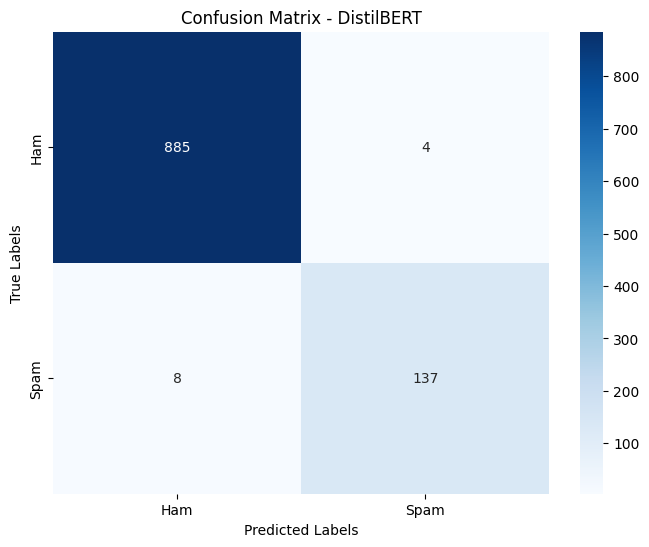

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
distilbert_conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(distilbert_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - DistilBERT")
plt.show()
